In [2]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Modelo SI com theta constante
def f(y, t, theta):
    S, I = y
    N = S + I
    
    dS = -theta * S * I/N
    dI = theta * S * I/N
    return np.array([dS, dI])

In [3]:
# Jacobianas para sensitividades
J = autograd.jacobian(f, argnum=0)
grad_theta = autograd.jacobian(f, argnum=2)

In [4]:
def ODESYS(Y, t, theta):
    dy_dt = f(Y[:2], t, theta)

    sensitivities = Y[2:].reshape(2, 1)  # 1 parâmetro
    
    grad = J(Y[:2], t, theta) @ sensitivities + np.stack([
        grad_theta(Y[:2], t, theta)
    ], axis=1)
    
    return np.concatenate([dy_dt, grad.flatten()])


def Cost(y_obs):
    def cost(Y):
        n = y_obs.shape[0]
        err = np.linalg.norm(y_obs - Y, 2, axis=1)
        return np.mean(err)/n
    return cost

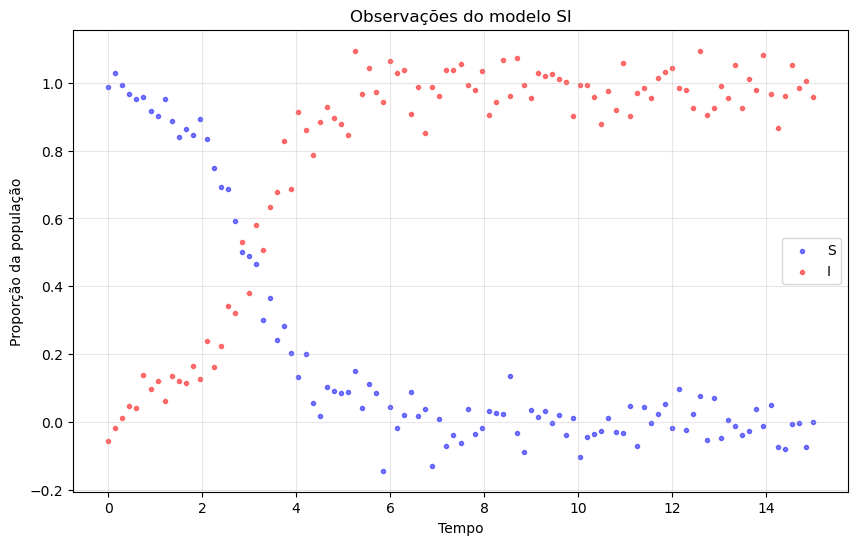

In [5]:
# Gerar dados sintéticos
np.random.seed(19920908)
Y0 = np.concatenate([np.array([0.97, 0.01]), np.zeros(2)])  # 2 estados + 2*1 sensitividades
t_span = (0, 15)
t_eval = np.linspace(*t_span, 101)
true_theta = 1.5

sol = solve_ivp(
    lambda t, y: ODESYS(y, t, true_theta),
    t_span, Y0, t_eval=t_eval, method='RK45'
)

y_obs = sol.y[:2].T + np.random.normal(0, 0.05, size=sol.y[:2].T.shape)

# Plot observações
plt.figure(figsize=(10, 6))
plt.scatter(t_eval, y_obs[:, 0], marker=".", alpha=0.5, label="S", color='blue')
plt.scatter(t_eval, y_obs[:, 1], marker=".", alpha=0.5, label="I", color='red')
plt.legend()
plt.title("Observações do modelo SI")
plt.xlabel("Tempo")
plt.ylabel("Proporção da população")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Gradiente descendente com busca linear
theta = 0.8  # Chute inicial
print(f"Valor verdadeiro: θ={true_theta:.4f}")
print(f"Chute inicial:    θ={theta:.4f}")
print("="*40)

cost = Cost(y_obs)
grad_c = autograd.grad(cost)

maxiter = 100
prev_cost = 1
tolerance = 1e-6
error_history = []
par_history = []

def line_search(theta, grad, sensitivities, Y, current_cost):
    alpha = 1.0
    beta = 0.5
    c = 1e-4
    new_cost = 2*current_cost

    s = c / np.linalg.norm(grad(Y))**2
    new_sensitivities = sensitivities

    while (new_cost > current_cost) and (s > 1e-10):
        s *= beta

        new_theta = theta - s * (grad(Y) * new_sensitivities[:, :, 0]).sum()

        # Garantir que theta seja positivo
        if new_theta <= 0:
            s *= 0.1
            continue

        sol = solve_ivp(
            lambda t, y: ODESYS(y, t, new_theta),
            t_span, Y0, t_eval=t_eval, method='RK45'
        )

        Y_new = sol.y[:2].T
        new_cost = cost(Y_new)
        new_sensitivities = sol.y[2:].T.reshape(-1, 2, 1)

    # Interpolação quadrática
    new_new_theta = new_theta - s * (grad(Y_new) * new_sensitivities[:, :, 0]).sum()
    
    if new_new_theta > 0:
        sol = solve_ivp(
            lambda t, y: ODESYS(y, t, new_new_theta),
            
            t_span, Y0, t_eval=t_eval, method='RK45'
        )
        Y_new_new = sol.y[:2].T
        new_new_cost = cost(Y_new_new)

        div1 = (new_cost - current_cost) / s
        div2 = (new_new_cost - 2*new_cost + current_cost)/(2*s*s)
        
        if div2 != 0:
            alpha = 0.5 * (s - div1/div2)
        else:
            alpha = s
    else:
        alpha = s
    
    if alpha <= 0:
        alpha = s

    return alpha

# Loop de otimização
for i in range(maxiter):
    sol = solve_ivp(
        lambda t, y: ODESYS(y, t, theta),
        t_span, Y0, t_eval=t_eval, method='RK45'
    )
    Y = sol.y[:2].T

    sensitivities = sol.y[2:].T.reshape(-1, 2, 1)

    current_cost = cost(Y)

    error_history.append(current_cost)
    par_history.append(theta)

    if abs((current_cost - prev_cost)/prev_cost) < tolerance and i > 0:
        print(f"Convergiu na iteração {i}")
        break

    prev_cost = current_cost

    alpha = line_search(theta, grad_c, sensitivities, Y, current_cost)

    theta_new = theta - alpha * (grad_c(Y) * sensitivities[:, :, 0]).sum()
    
    # Garantir que theta seja positivo
    if theta_new > 0:
        theta = theta_new
    else:
        theta *= 0.9  # Reduzir gradualmente se ficar negativo

    if i % 5 == 0:
        print(f"Iter {i}: θ={theta:.4f}, α={alpha:.4f}, custo={current_cost:.4f}")


Valor verdadeiro: θ=1.5000
Chute inicial:    θ=0.8000
Iter 0: θ=1.3972, α=99.4181, custo=0.0027
Iter 5: θ=1.5050, α=74.3941, custo=0.0007
Convergiu na iteração 6


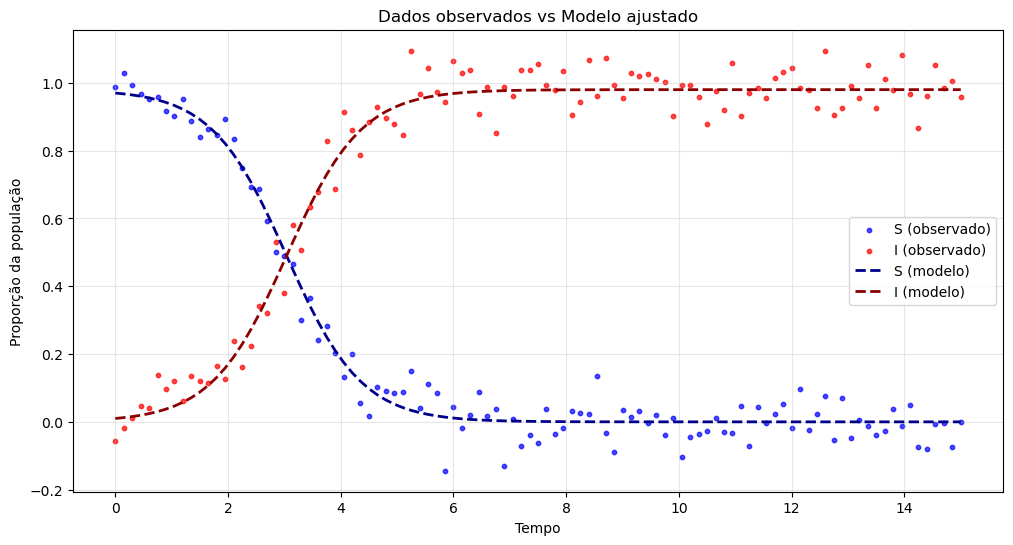

In [8]:
# Plot 1: Observações vs modelo final
sol_final = solve_ivp(
    lambda t, y: ODESYS(y, t, theta),
    t_span, Y0, t_eval=t_eval, method='RK45'
)
y_final = sol_final.y[:2].T

plt.figure(figsize=(12, 6))

plt.scatter(t_eval, y_obs[:, 0], alpha=0.7, label='S (observado)', color='blue', s=10)
plt.scatter(t_eval, y_obs[:, 1], alpha=0.7, label='I (observado)', color='red', s=10)

plt.plot(t_eval, y_final[:, 0], '--', label='S (modelo)', color='darkblue', linewidth=2)
plt.plot(t_eval, y_final[:, 1], '--', label='I (modelo)', color='darkred', linewidth=2)

plt.xlabel('Tempo')
plt.ylabel('Proporção da população')
plt.title('Dados observados vs Modelo ajustado')
plt.legend()
plt.grid(True, alpha=0.3)

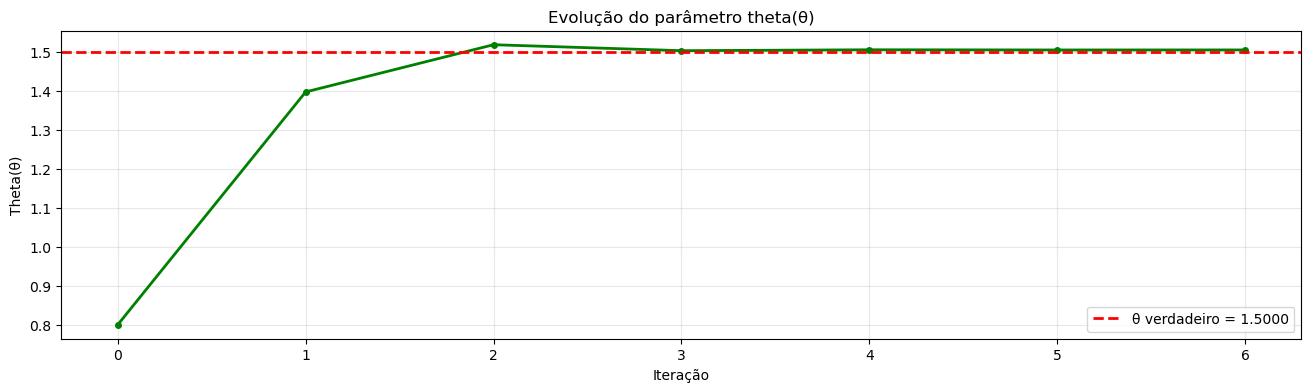

In [12]:
# Plot da evolução do parâmetro durante a otimização
plt.figure(figsize=(16, 4))

plt.plot(par_history, 'g-', linewidth=2, marker='o', markersize=4)
plt.axhline(y=true_theta, color='r', linestyle='--', linewidth=2, label=f'θ verdadeiro = {true_theta:.4f}')
plt.xlabel('Iteração')
plt.ylabel('Theta(θ)')
plt.title('Evolução do parâmetro theta(θ)')
plt.legend()
plt.grid(True, alpha=0.3)


plt.show()